### 1. Load and visualize data

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
IMAGE_DIR= 'frames'
MASK_DIR = 'masks'

In [5]:
image_filenames = sorted(os.listdir(IMAGE_DIR))
mask_filenames = sorted(os.listdir(MASK_DIR))

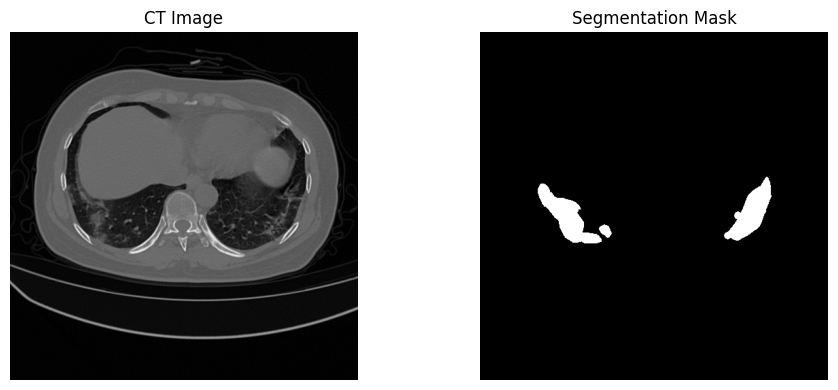

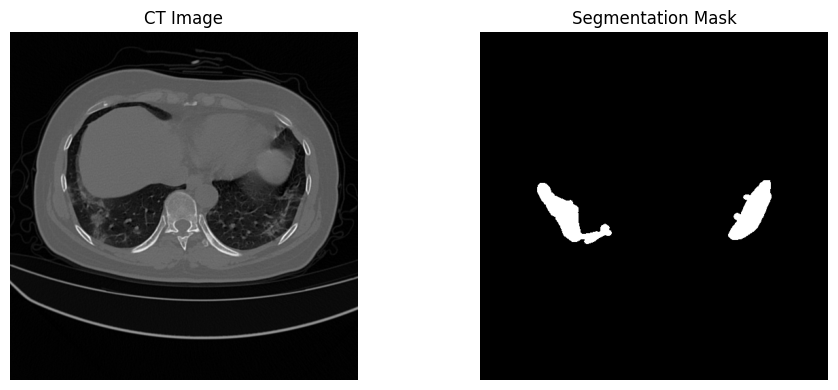

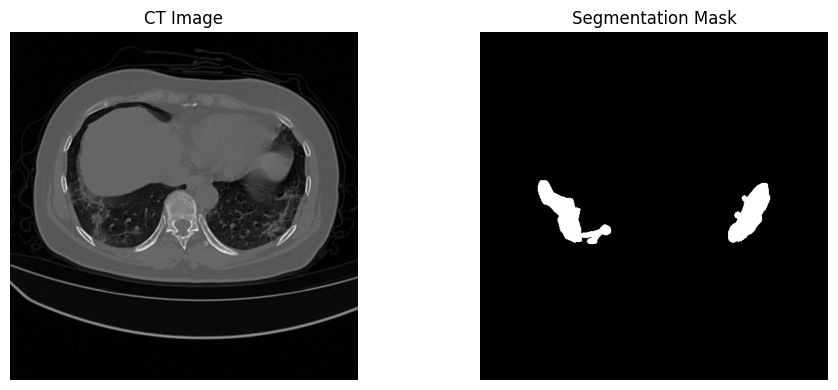

In [6]:
def visualize_sample(index):
    img_path = os.path.join(IMAGE_DIR, image_filenames[index])
    mask_path = os.path.join(MASK_DIR, mask_filenames[index])

    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title("CT Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Segmentation Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

for i in range(3):
    visualize_sample(i)

### 2. Preprocessing

In [7]:
from sklearn.model_selection import train_test_split

In [10]:
import os
import cv2

In [12]:
IMAGE_DIR = "frames"
MASK_DIR = "masks"

IMG_HEIGHT, IMG_WIDTH = 128, 128

images = []
masks = []

image_filenames = sorted(os.listdir(IMAGE_DIR))
mask_filenames = sorted(os.listdir(MASK_DIR))

for img_file, mask_file in zip(image_filenames, mask_filenames):
    img_path = os.path.join(IMAGE_DIR, img_file)
    mask_path = os.path.join(MASK_DIR, mask_file)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))

    img = img/255.0
    mask = mask/255.0

    img = np.expand_dims(img, axis=-1)
    mask = np.expand_dims(mask, axis=-1)

    images.append(img)
    masks.append(mask)


In [13]:
images = np.array(images)
masks = np.array(masks)

X_train, X_val, y_train, y_val = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)

Training data shape: (2183, 128, 128, 1)
Validation data shape: (546, 128, 128, 1)


### 3. U-net Model

In [16]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate

In [17]:
def unet_model(input_size=(128, 128, 1)):
    inputs= Input(input_size)

    #Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D()(c3)

    #Bottleneck
    c4 = Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(512, 3, activation='relu', padding='same')(c4)

    #Decoder
    u5 = UpSampling2D()(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, 3, activation='relu', padding='same')(u5)
    c5 = Conv2D(256, 3, activation='relu', padding='same')(c5)

    u6 = UpSampling2D()(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(128, 3, activation='relu', padding='same')(c6)

    u7 = UpSampling2D()(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(64, 3, activation='relu', padding='same')(c7)

    #output
    outputs = Conv2D(1, 1, activation='sigmoid')(c7)

    model = Model(inputs=inputs, outputs=outputs)
    return model



### 4. Train the model

In [18]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
model= unet_model(input_size=(128, 128, 1))

In [27]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=BinaryCrossentropy(),
              metrics=['accuracy', MeanIoU(num_classes=2)])

checkpoint = ModelCheckpoint("best_unet.h5", save_best_only=True, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=4,
    epochs=20,
    callbacks=[checkpoint]
)

Epoch 1/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9871 - loss: 0.0338 - mean_io_u_7: 0.4930
Epoch 1: val_loss improved from inf to 0.03158, saving model to best_unet.h5


546/546 ━━━━━━━━━━━━━━━━━━━━ 761s 1s/step - accuracy: 0.9871 - loss: 0.0338 - mean_io_u_7: 0.4930 - val_accuracy: 0.9882 - val_loss: 0.0316 - val_mean_io_u_7: 0.4928
Epoch 2/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9894 - loss: 0.0263 - mean_io_u_7: 0.4930
Epoch 2: val_loss improved from 0.03158 to 0.02625, saving model to best_unet.h5


546/546 ━━━━━━━━━━━━━━━━━━━━ 716s 1s/step - accuracy: 0.9894 - loss: 0.0263 - mean_io_u_7: 0.4930 - val_accuracy: 0.9892 - val_loss: 0.0262 - val_mean_io_u_7: 0.4928
Epoch 3/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9905 - loss: 0.0224 - mean_io_u_7: 0.4930
Epoch 3: val_loss improved from 0.02625 to 0.02354, saving model to best_unet.h5


546/546 ━━━━━━━━━━━━━━━━━━━━ 825s 2s/step - accuracy: 0.9905 - loss: 0.0224 - mean_io_u_7: 0.4930 - val_accuracy: 0.9900 - val_loss: 0.0235 - val_mean_io_u_7: 0.4928
Epoch 4/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9914 - loss: 0.0193 - mean_io_u_7: 0.4930
Epoch 4: val_loss improved from 0.02354 to 0.02012, saving model to best_unet.h5


546/546 ━━━━━━━━━━━━━━━━━━━━ 813s 1s/step - accuracy: 0.9914 - loss: 0.0193 - mean_io_u_7: 0.4930 - val_accuracy: 0.9911 - val_loss: 0.0201 - val_mean_io_u_7: 0.4928
Epoch 5/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9923 - loss: 0.0166 - mean_io_u_7: 0.4932
Epoch 5: val_loss improved from 0.02012 to 0.01764, saving model to best_unet.h5


546/546 ━━━━━━━━━━━━━━━━━━━━ 766s 1s/step - accuracy: 0.9923 - loss: 0.0166 - mean_io_u_7: 0.4932 - val_accuracy: 0.9919 - val_loss: 0.0176 - val_mean_io_u_7: 0.4928
Epoch 6/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9935 - loss: 0.0136 - mean_io_u_7: 0.4937
Epoch 6: val_loss improved from 0.01764 to 0.01724, saving model to best_unet.h5


546/546 ━━━━━━━━━━━━━━━━━━━━ 763s 1s/step - accuracy: 0.9935 - loss: 0.0136 - mean_io_u_7: 0.4937 - val_accuracy: 0.9919 - val_loss: 0.0172 - val_mean_io_u_7: 0.4928
Epoch 7/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9926 - loss: 0.0156 - mean_io_u_7: 0.4932
Epoch 7: val_loss improved from 0.01724 to 0.01597, saving model to best_unet.h5


546/546 ━━━━━━━━━━━━━━━━━━━━ 685s 1s/step - accuracy: 0.9926 - loss: 0.0156 - mean_io_u_7: 0.4932 - val_accuracy: 0.9924 - val_loss: 0.0160 - val_mean_io_u_7: 0.4928
Epoch 8/20
161/546 ━━━━━━━━━━━━━━━━━━━━ 8:51 1s/step - accuracy: 0.9939 - loss: 0.0118 - mean_io_u_7: 0.4934

KeyboardInterrupt: 

NameError: name 'history' is not defined

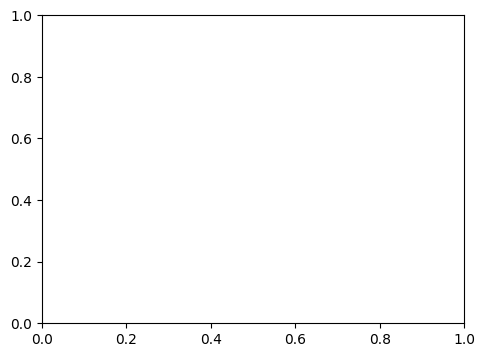

In [28]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label="val loss")
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()